### Загрузка библиотек

In [1]:
import pandas as pd;
import numpy as np;
import scipy as sp;
from sklearn.model_selection import train_test_split;
from statsmodels.miscmodels.ordinal_model import OrderedModel;
from statsmodels.tools.tools import add_constant;
import seaborn as sns;
import matplotlib.pyplot as plt;
from sklearn.preprocessing import OneHotEncoder;
from sklearn import metrics;


from special_cross_tables import relative_cross_tab_by_rows;
from chi_sq_test_parts import simple_chi_sq_test;

# Подготовка и исследование данных

### Загрузим массив данных и получим недостающие колонки

In [2]:
data = pd.read_csv('input_data.csv', index_col= 0)
data.head()

,default_days,sex,age,income_level_BYR,registration_date,repayment_date,contract_summ,СВ_30_days,force_contract,real_estate,Education,dependents_count
0,0.0,Female,21.0,912.0,2016-08-27,2018-03-27,1000.0,1.0,0.0,Yes,среднее специальное,0.0
1,1.0,Female,27.0,1045.0,2016-07-08,2017-02-05,196.0,2.0,0.0,Yes,высшее,1.0
2,0.0,Female,55.0,1509.0,2016-08-12,2017-01-10,30.0,8.0,0.0,No,среднее,0.0
3,11.0,Female,40.0,1592.0,2016-09-05,2017-01-03,628.0,1.0,0.0,No,среднее,0.0
4,39.0,Male,24.0,816.0,2016-09-26,2018-05-27,2000.0,0.0,2.0,Yes,среднее специальное,1.0


In [3]:
# тут 3 вида дефолта:
# нет дефолта (0-30) 0
# легкий дефолт (31-60) 1
# тяжелый дефолт (>61) 2
data.loc[data['default_days'] <= 30, 'default_type'] = 0
data.loc[(data['default_days'] <= 60) & (data['default_days'] > 30), 'default_type'] = 1
data.loc[data['default_days'] > 60, 'default_type'] = 2

### Сумму кредитного договора не слишком целесообразно использовать в качесве предиктора, лучше использовать размер ежемесячного платежа - создадим его

In [4]:
# приводим даты, которые загрузились как строки к типу 'datetime'
data['registration_date'] = pd.to_datetime(data['registration_date'] )
data['repayment_date'] = pd.to_datetime(data['repayment_date'] )

# получаем на сколько месяцев был рассчитан кредит
data['month_term'] = (data['repayment_date'] - data['registration_date'])/np.timedelta64(1, 'M')

# получаем показатель ежемесячный палатеж
data['monthly_payment'] = data['contract_summ'] / data['month_term']

## Проведем исследование числовых предикторов

выделим те предикторы которые могут быть интерпретированы как число

In [5]:
number_preds = data.columns[(data.dtypes == 'float64') & (np.invert(data.columns.isin(['default_type', 'default_days'])))]
number_preds

Index(['age', 'income_level_BYR', 'contract_summ', 'СВ_30_days',
       'force_contract', 'dependents_count', 'month_term', 'monthly_payment'],
      dtype='object')

#### начнем с визуализации - хороший вариант ящик с усами и добавим гистограммы распределения

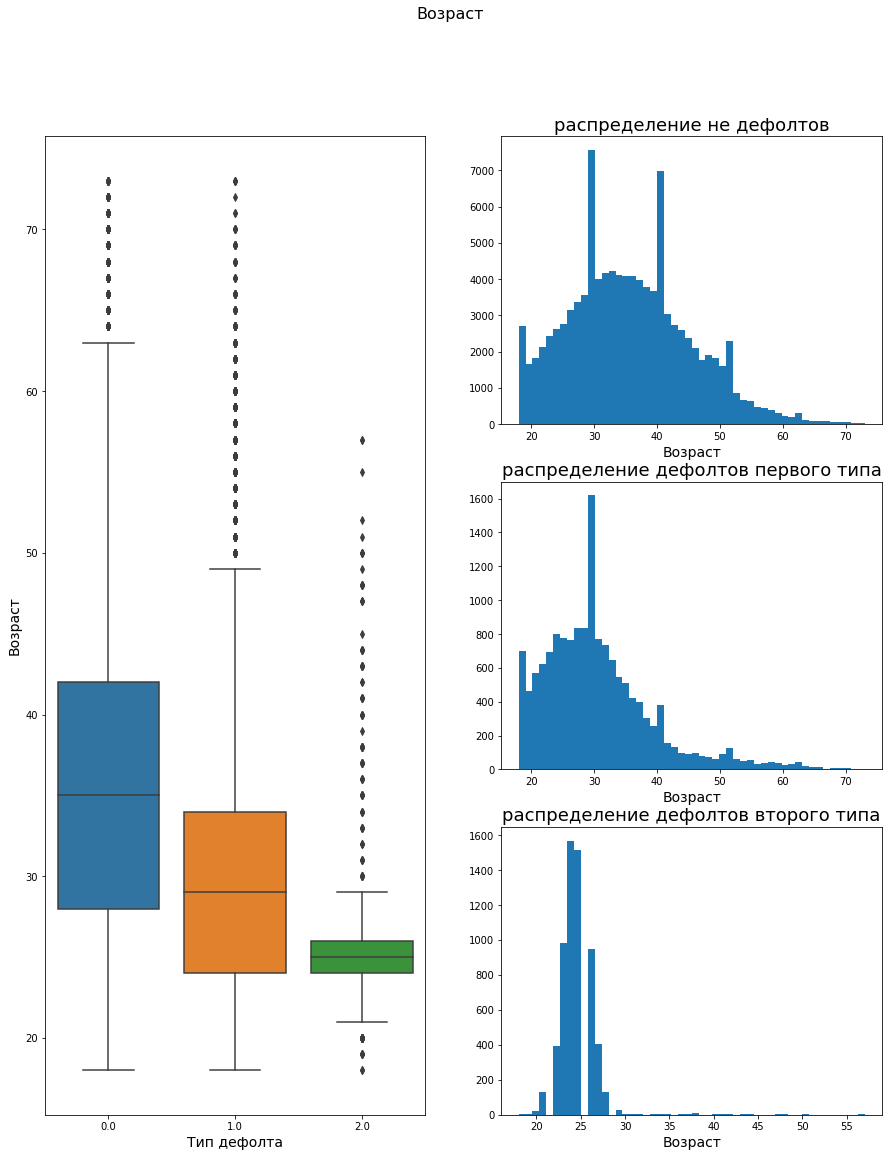

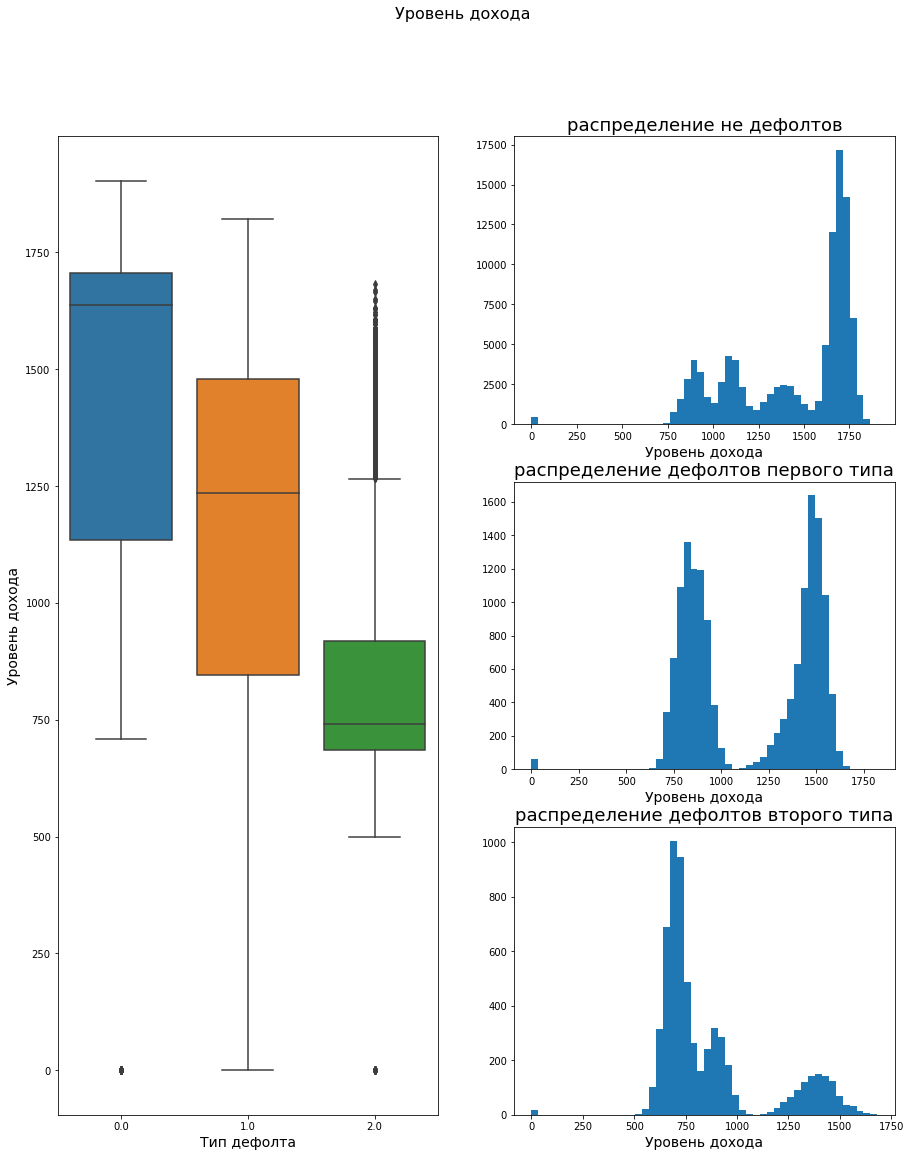

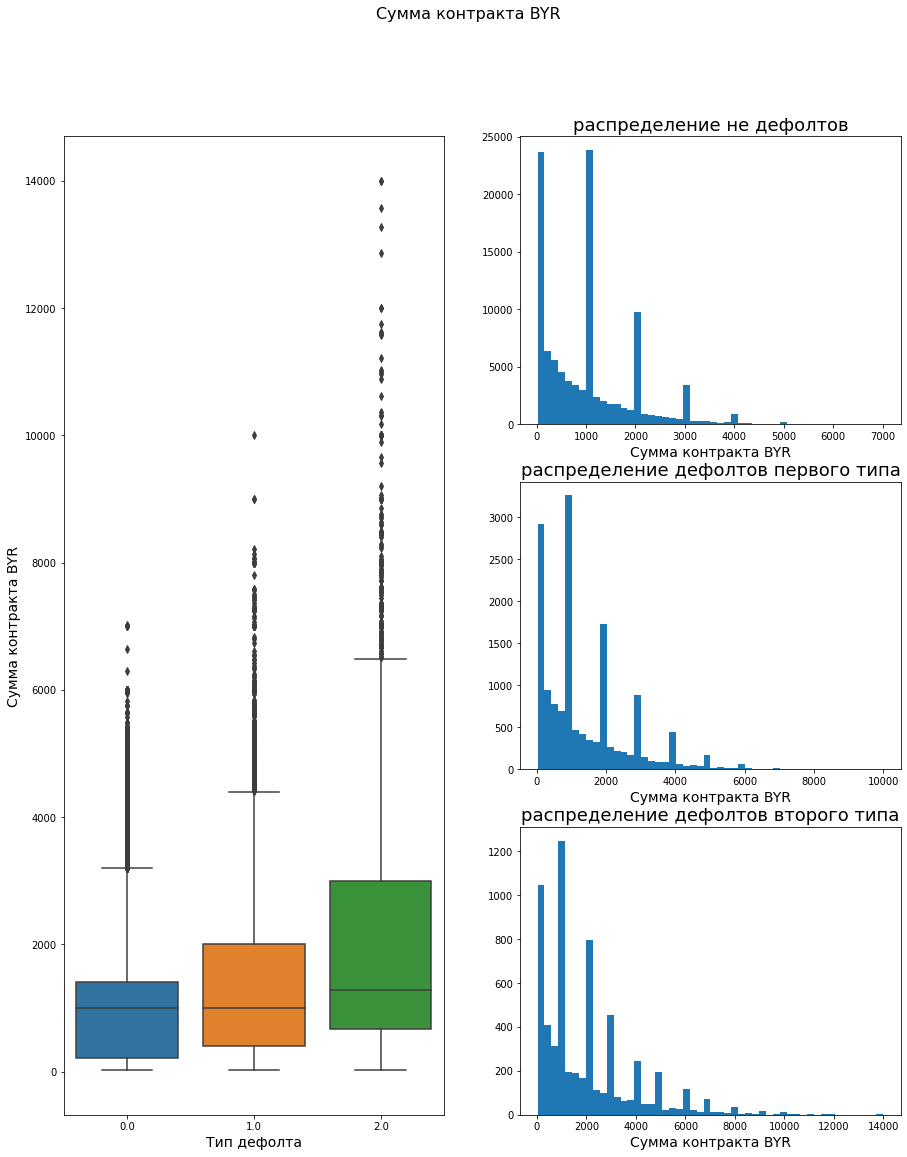

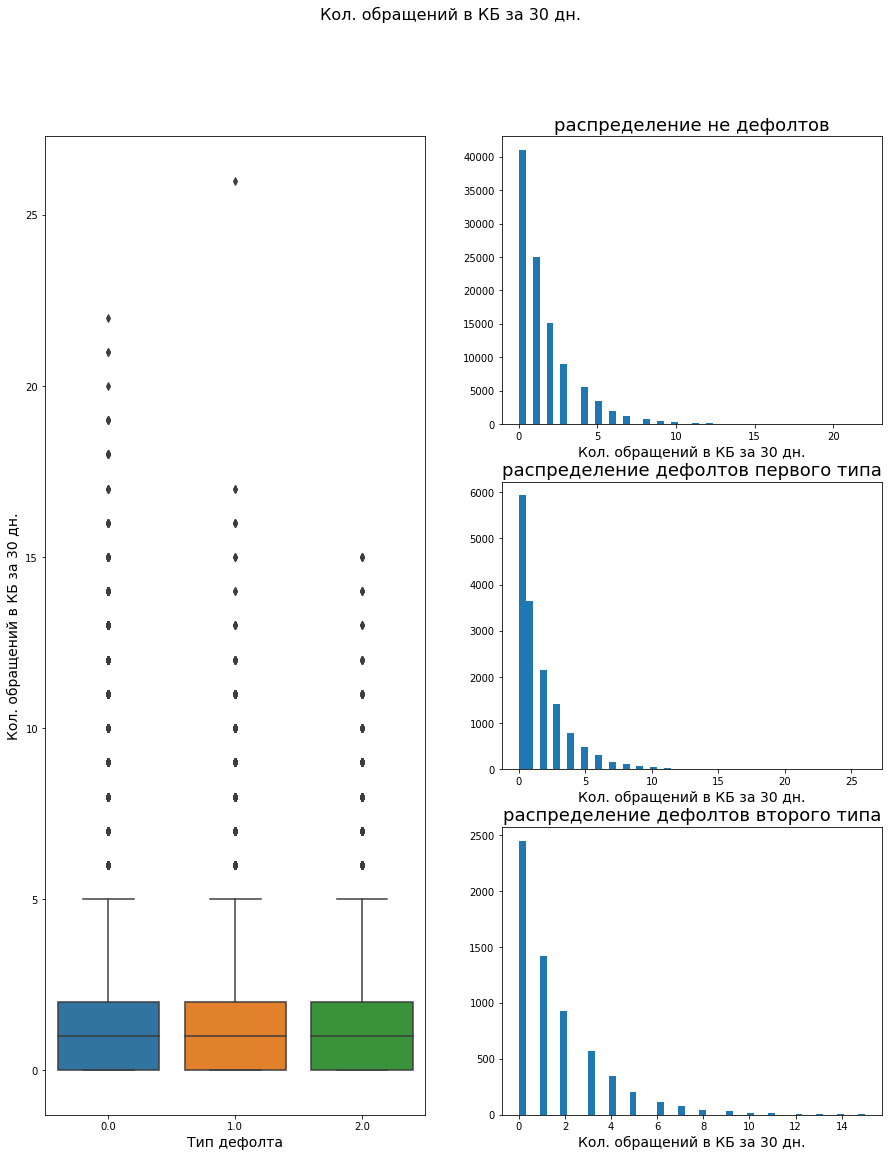

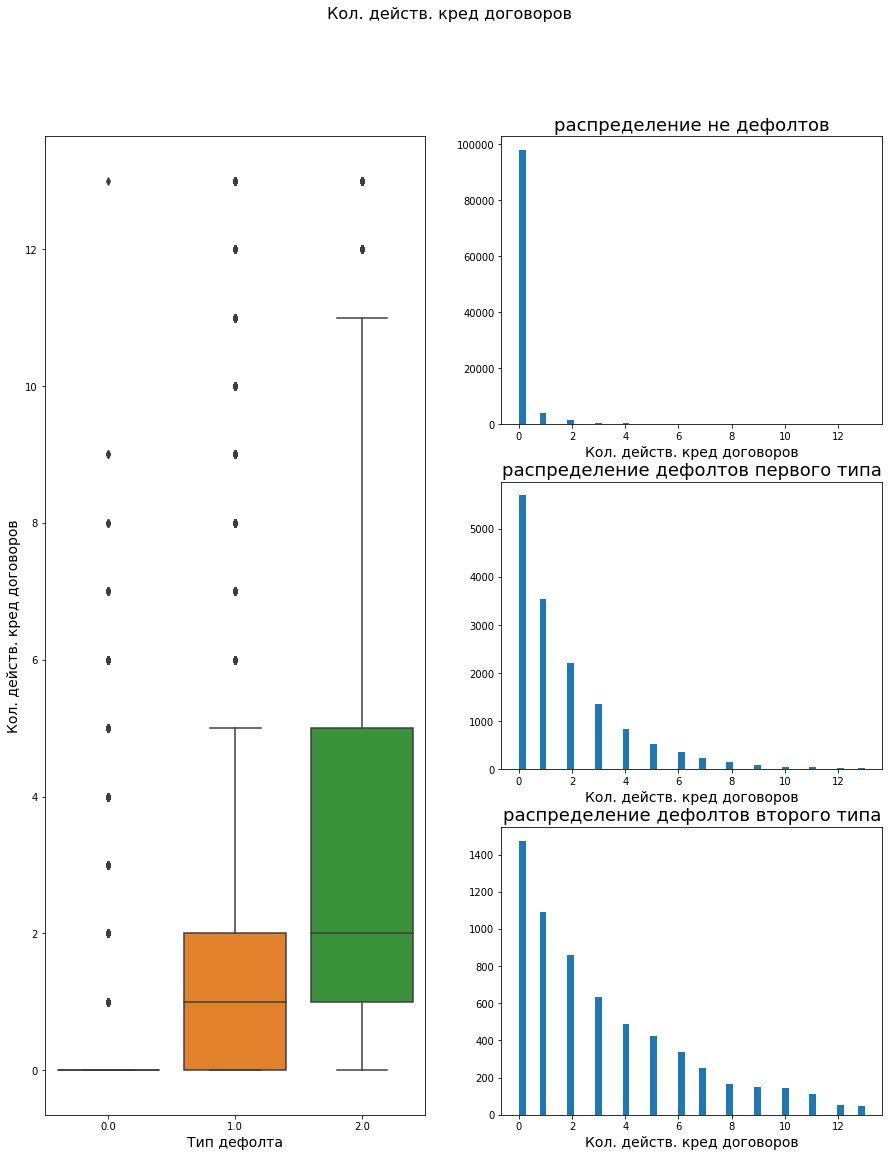

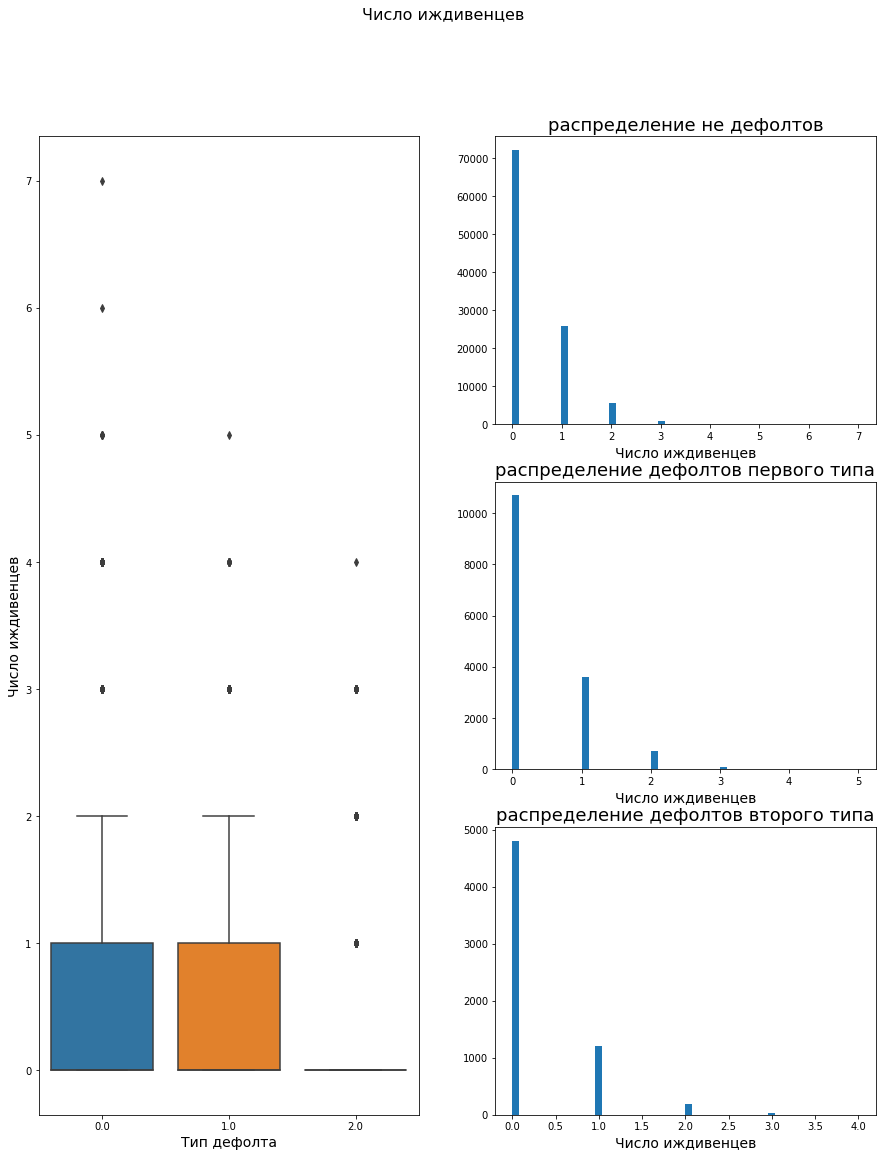

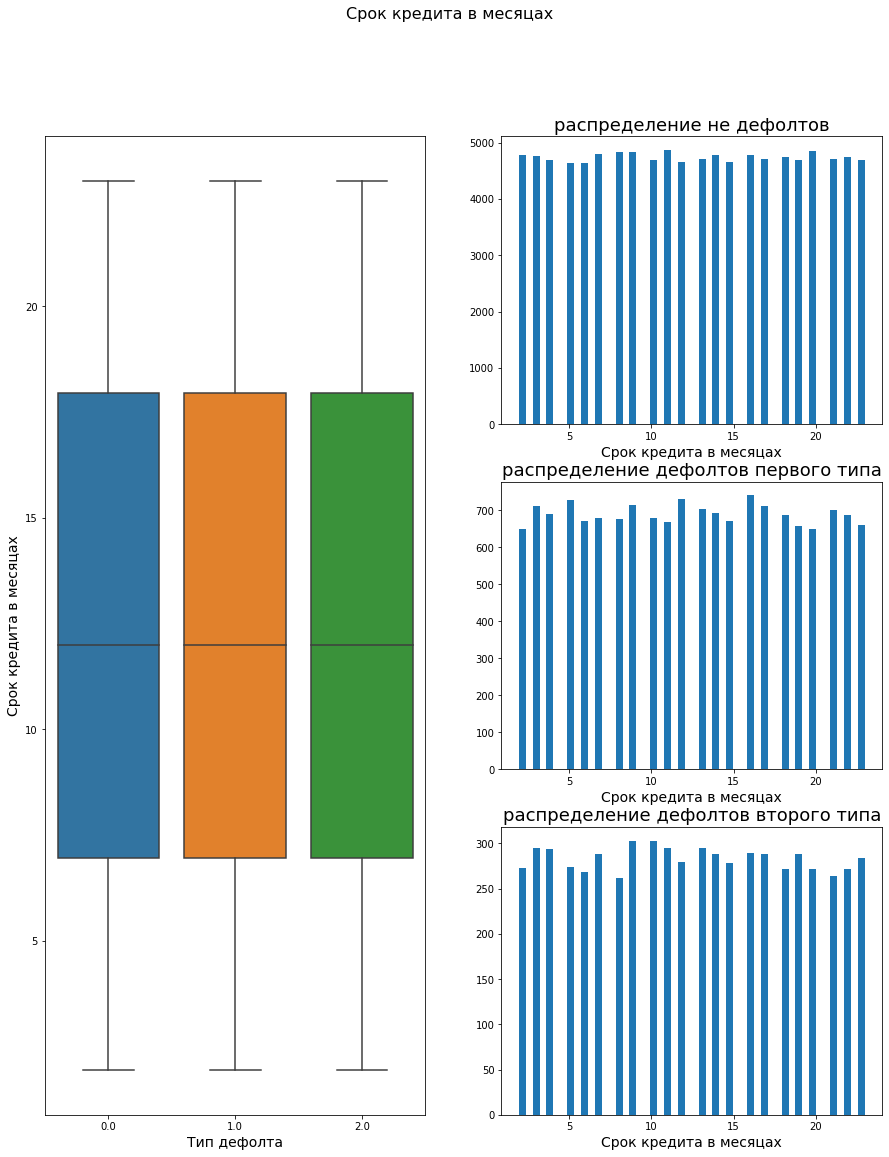

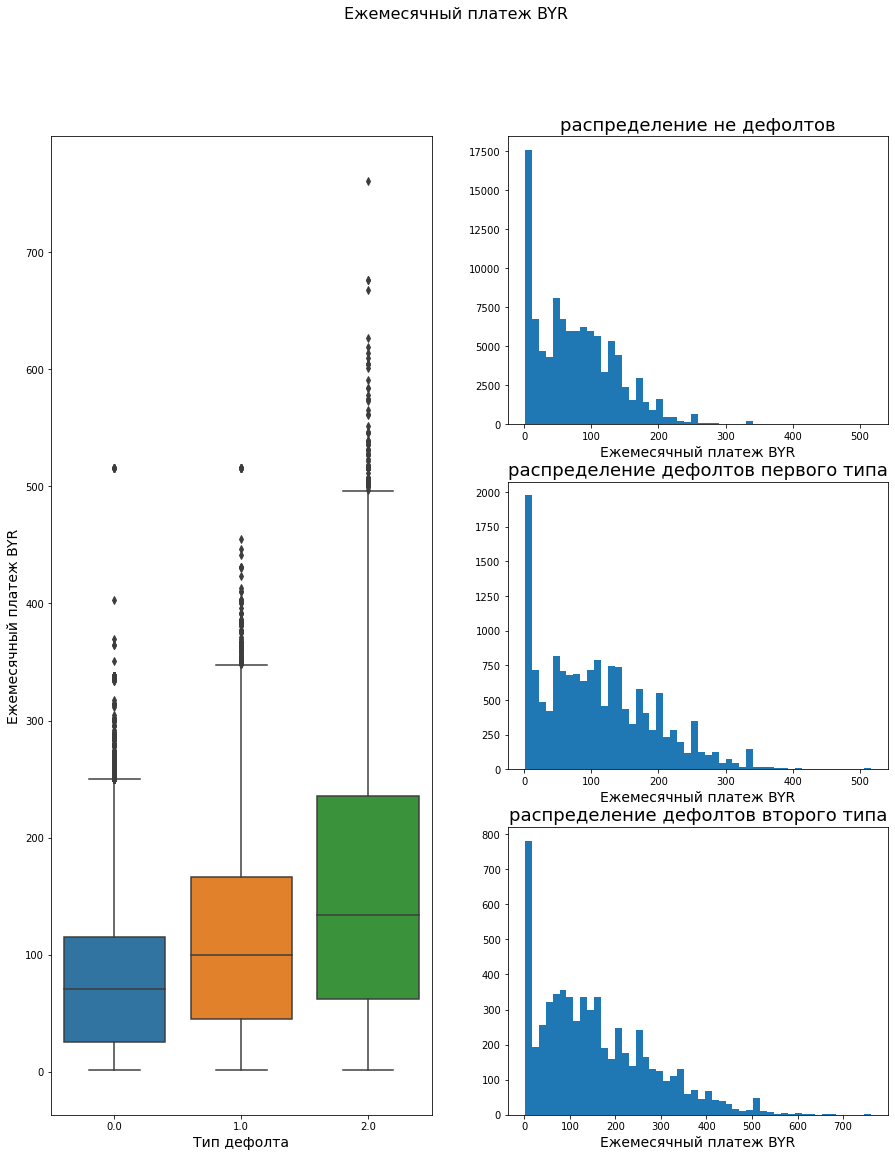

In [6]:
pred_names = ['Возраст', 'Уровень дохода', 'Сумма контракта BYR', 'Кол. обращений в КБ за 30 дн.'
, 'Кол. действ. кред договоров', 'Число иждивенцев', 'Срок кредита в месяцах','Ежемесячный платеж BYR']

for i, pred in enumerate(number_preds):
    fig = plt.figure(figsize = [15,18])

    ax = plt.subplot(1,2,1)
    sns.boxplot( x = 'default_type', y = pred, data = data)
    ax.set_xlabel('Тип дефолта', fontsize = 14)
    ax.set_ylabel(pred_names[i], fontsize = 14)

    ax = plt.subplot(3,2,2)
    plt.hist(data.loc[data['default_type'] == 0, pred], bins = 50)
    ax.set_xlabel(pred_names[i], fontsize = 14)
    plt.title('распределение не дефолтов', fontsize = 18)

    ax = plt.subplot(3,2,4)
    plt.hist(data.loc[data['default_type'] == 1, pred], bins = 50)
    ax.set_xlabel(pred_names[i], fontsize = 14)
    plt.title('распределение дефолтов первого типа', fontsize = 18)

    ax = plt.subplot(3,2,6)
    plt.hist(data.loc[data['default_type'] == 2, pred], bins = 50)
    ax.set_xlabel(pred_names[i], fontsize = 14)
    plt.title('распределение дефолтов второго типа', fontsize = 18)

    fig.suptitle(pred_names[i], fontsize = 16)
    plt.savefig('pirctures/' + pred_names[i] + '_order.png')
    

#### Критерий Краскелла-Уолиса

In [7]:
for i, pred in enumerate(number_preds):
    print('результаты теста для показателя ' + pred_names[i])
    print(  sp.stats.kruskal(   data.loc[data.default_type == 0, pred ], 
                                data.loc[data.default_type == 1, pred ],
                                data.loc[data.default_type == 2, pred ]))

результаты теста для показателя Возраст
KruskalResult(statistic=12760.218173480205, pvalue=0.0)
результаты теста для показателя Уровень дохода
KruskalResult(statistic=22704.56384170489, pvalue=0.0)
результаты теста для показателя Сумма контракта BYR
KruskalResult(statistic=2618.130730402441, pvalue=0.0)
результаты теста для показателя Кол. обращений в КБ за 30 дн.
KruskalResult(statistic=0.7068392405919731, pvalue=0.7022824395740672)
результаты теста для показателя Кол. действ. кред договоров
KruskalResult(statistic=50308.0938774048, pvalue=0.0)
результаты теста для показателя Число иждивенцев
KruskalResult(statistic=196.64824010481416, pvalue=1.987820766227919e-43)
результаты теста для показателя Срок кредита в месяцах
KruskalResult(statistic=0.5317948699257007, pvalue=0.7665177413900535)
результаты теста для показателя Ежемесячный платеж BYR
KruskalResult(statistic=4423.881362793557, pvalue=0.0)


#### Разберемся с проблемой показателя - число иждивенцев

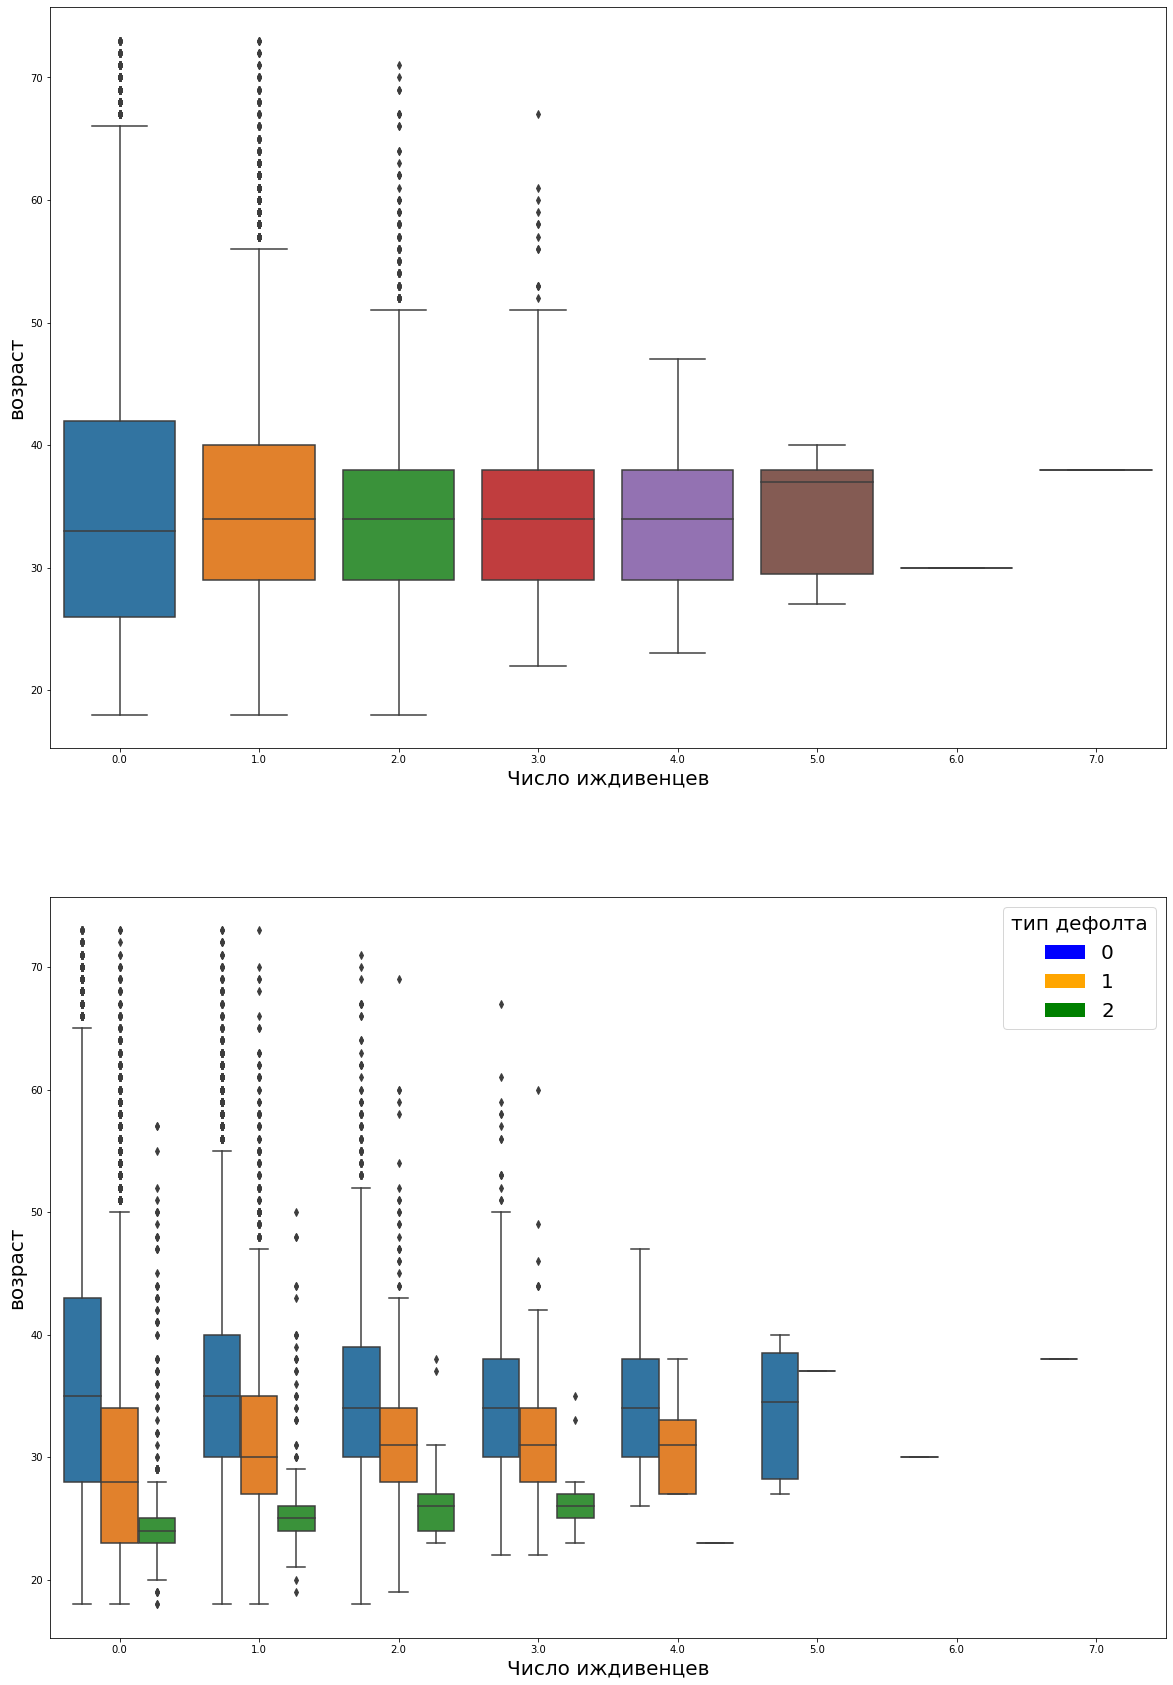

In [8]:
plt.figure(figsize = [20,30])

ax = plt.subplot(2,1,1)
sns.boxplot(x="dependents_count", y="age", data=data)
ax.set_xlabel("Число иждивенцев", fontsize = 20)
ax.set_ylabel("возраст", fontsize = 20)

ax = plt.subplot(2,1,2)
sns.boxplot(x="dependents_count", y="age", hue="default_type", data=data)
ax.set_xlabel("Число иждивенцев", fontsize = 20)
ax.set_ylabel("возраст", fontsize = 20)

# тонкая настройка легенды

from matplotlib.patches import Patch
legend_elements = [ Patch(facecolor='b',  label='0'),
                    Patch(facecolor='orange',  label='1'),
                    Patch(facecolor='g',  label='2')]

plt.legend(handles = legend_elements,fontsize=20, title="тип дефолта", title_fontsize = 20) # using a size in points
plt.savefig('pirctures/age_depend_res.png')


## Проведем исследование номинативных предикторов

In [9]:
nomin_preds = data.columns[(data.dtypes != 'float64') & (np.invert(data.columns.isin(['registration_date', 'repayment_date'])))]
nomin_preds

Index(['sex', 'real_estate', 'Education'], dtype='object')

### Построим таблицы сопряженности

In [10]:
tables = {}

for pred in nomin_preds:
    tables[pred] = relative_cross_tab_by_rows(data[pred], data['default_type'])
    tables[pred].to_excel('work_tables/' + pred + '_order.xlsx')
    print(tables[pred])

          0.0   1.0   2.0      0.0%      1.0%      2.0%
sex                                                    
Female  62634  7424  2810  0.859554  0.101883  0.038563
Male    41627  7730  3414  0.788823  0.146482  0.064695
               0.0   1.0   2.0      0.0%      1.0%      2.0%
real_estate                                                 
No           58021  8787  3550  0.824654  0.124890  0.050456
Yes          46240  6367  2674  0.836454  0.115175  0.048371
                        0.0   1.0   2.0      0.0%      1.0%      2.0%
Education                                                            
высшее                41739  4124   797  0.894535  0.088384  0.017081
незаконченное высшее   5166  1164   815  0.723023  0.162911  0.114066
неполное среднее       3083   597   360  0.763119  0.147772  0.089109
среднее               26267  4595  2151  0.795656  0.139188  0.065156
среднее специальное   28006  4674  2101  0.805210  0.134384  0.060407


### Проверим по критерию Хи квадрат

In [11]:
for pred in nomin_preds:
    print('==================================')
    simple_chi_sq_test(data.loc[:, pred], data.loc[:, 'default_type'], data.loc[:, pred].unique())

Нулевую гипотезу следует отклонить. (о равенстве долей в группах)
сравниваемые уровни ['Female' 'Male']
p значение: 0.0
значение статистики: 689.2414010510067
критический уровень: 5.991464547107979
Нулевую гипотезу следует отклонить. (о равенстве долей в группах)
сравниваемые уровни ['Yes' 'No']
p значение: 4.095143517623967e-07
значение статистики: 29.416587774194166
критический уровень: 5.991464547107979
Нулевую гипотезу следует отклонить. (о равенстве долей в группах)
сравниваемые уровни ['среднее специальное' 'высшее' 'среднее' 'незаконченное высшее'
 'неполное среднее']
p значение: 0.0
значение статистики: 1108.7890522808757
критический уровень: 15.50731305586545


## По результатам анализа удалим ряд столбцов

In [12]:
columns_to_drop = ['default_days', 'registration_date','repayment_date', 'contract_summ', 'СВ_30_days', 'dependents_count', 'month_term'];
data.drop(columns_to_drop, axis = 1, inplace=True)
data.head()

,sex,age,income_level_BYR,force_contract,real_estate,Education,default_type,monthly_payment
0,Female,21.0,912.0,0.0,Yes,среднее специальное,0.0,52.750217
1,Female,27.0,1045.0,0.0,Yes,высшее,0.0,28.139752
2,Female,55.0,1509.0,0.0,No,среднее,0.0,6.047061
3,Female,40.0,1592.0,0.0,No,среднее,0.0,159.286313
4,Male,24.0,816.0,2.0,Yes,среднее специальное,1.0,100.121299


# Построение модели

#### Требуется провести перекодировку номинативных предикторов

In [13]:
# список предикторов подлежащих преобразованию
nomin_preds = data.columns[(data.dtypes != 'float64') & (np.invert(data.columns.isin(['registration_date', 'repayment_date'])))]
print(nomin_preds)

encoder = OneHotEncoder(handle_unknown = 'ignore')

encodet_nomin_preds = encoder.fit_transform(data.loc[:,nomin_preds])
encdet_data_frame = pd.DataFrame(encodet_nomin_preds.toarray(), columns = encoder.get_feature_names(nomin_preds))
data = pd.concat([data, encdet_data_frame], axis = 1)

data.drop(nomin_preds, axis = 1, inplace = True)

Index(['sex', 'real_estate', 'Education'], dtype='object')


C:\Users\Dranik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Данной модели не требуется явно указывать совбодный член - он зависит от уровня предсказываемого фактора, но от каждого номинативного столбца все равно следует удалить по одному уровню

In [14]:
data.drop(['sex_Female', 'Education_высшее','real_estate_No'], axis = 1, inplace = True)

data.head()

,age,income_level_BYR,force_contract,default_type,monthly_payment,sex_Male,real_estate_Yes,Education_незаконченное высшее,Education_неполное среднее,Education_среднее,Education_среднее специальное
0,21.0,912.0,0.0,0.0,52.750217,0.0,1.0,0.0,0.0,0.0,1.0
1,27.0,1045.0,0.0,0.0,28.139752,0.0,1.0,0.0,0.0,0.0,0.0
2,55.0,1509.0,0.0,0.0,6.047061,0.0,0.0,0.0,0.0,1.0,0.0
3,40.0,1592.0,0.0,0.0,159.286313,0.0,0.0,0.0,0.0,1.0,0.0
4,24.0,816.0,2.0,1.0,100.121299,1.0,1.0,0.0,0.0,0.0,1.0


### Разбиение выборки на обучающую и валидационную

In [15]:
[train_data, test_data] = train_test_split(data, test_size = 0.3, train_size = 0.7,random_state=4)

### Оценка коэффициентов модели
https://www.statsmodels.org/dev/examples/notebooks/generated/ordinal_regression.html пример
https://www.statsmodels.org/dev/generated/statsmodels.miscmodels.ordinal_model.OrderedModel.html документация

In [16]:
model = OrderedModel(train_data.loc[:,'default_type'], train_data.loc[:,train_data.columns != 'default_type']).fit(maxiter = 2207)
model.summary()

Optimization terminated successfully.
         Current function value: 0.376689
         Iterations: 1534
         Function evaluations: 2146


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:           default_type   Log-Likelihood:                -33129.
Model:                   OrderedModel   AIC:                         6.628e+04
Method:            Maximum Likelihood   BIC:                         6.639e+04
Date:                Sat, 18 Dec 2021                                         
Time:                        05:13:41                                         
No. Observations:               87947                                         
Df Residuals:                   87935                                         
Df Model:                          12                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
age                               -0.0127      0.001    -16.781      0.000      -0.014      -0.011
income_level_BYR                  -0.0016   1.99e-05    -78.132      0.000      -0.002      -0.002
force_contract                     0.3259      0.004     89.714      0.000       0.319       0.333
monthly_payment                    0.0040   7.46e-05     53.607      0.000       0.004       0.004
sex_Male                          -0.3710      0.012    -31.288      0.000      -0.394      -0.348
real_estate_Yes                   -0.4424      0.012    -35.877      0.000      -0.467      -0.418
Education_незаконченное высшее     0.2939      0.024     12.306      0.000       0.247       0.341
Education_неполное среднее         0.0180      0.033      0.552      0.581      -0.046       0.082
Education_среднее                  0.2513      0.015     17.096      0.000       0.222       0.280
Education_среднее специальное      0.0047      0.015      0.315      0.753      -0.025       0.034
0.0/1.0                           -1.1136      0.030    -37.543      0.000      -1.172      -1.055
1.0/2.0                            0.1766      0.009     19.179      0.000       0.159       0.195
==================================================================================================
"""

####  Попробуем объединить "Education_незаконченное высшее" и "Education_неполное среднее" в едином предикторе - для того, чтобы устранить незначимость коэффициента

In [17]:
# поставим в новой колонке 1 только в том случае если в объединяемых колонках есть хоть одна
# единичка в соответвующих строках
col1_bool = data['Education_среднее специальное'].astype('bool');
col2_bool = data['Education_неполное среднее'].astype('bool');
data['Education_среднее специальное/неполное среднее'] = (col1_bool | col2_bool).astype('float32')

#data.loc[:, ['Education_незаконченное высшее', 'Education_неполное среднее', 'Education_незаконченное высшее/неполное среднее']].head()
data.drop(['Education_среднее специальное', 'Education_неполное среднее'], axis = 1, inplace = True)

#### Заново проведем оцениваание коэффициентов

In [18]:
[train_data, test_data] = train_test_split(data, test_size = 0.3, train_size = 0.7,random_state=4)

model = OrderedModel(train_data.loc[:,'default_type'], train_data.loc[:,train_data.columns != 'default_type']).fit(maxiter = 2207)
model.summary()

Optimization terminated successfully.
         Current function value: 0.365837
         Iterations: 2060
         Function evaluations: 2855


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:           default_type   Log-Likelihood:                -32174.
Model:                   OrderedModel   AIC:                         6.437e+04
Method:            Maximum Likelihood   BIC:                         6.447e+04
Date:                Sat, 18 Dec 2021                                         
Time:                        05:14:35                                         
No. Observations:               87947                                         
Df Residuals:                   87936                                         
Df Model:                          11                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
age                                               -0.0120      0.001    -15.741      0.000      -0.014      -0.011
income_level_BYR                                  -0.0015   2.01e-05    -76.029      0.000      -0.002      -0.001
force_contract                                     0.3749      0.004    100.772      0.000       0.368       0.382
monthly_payment                                    0.0040   7.53e-05     52.680      0.000       0.004       0.004
sex_Male                                           0.2251      0.012     19.316      0.000       0.202       0.248
real_estate_Yes                                   -0.4014      0.012    -32.302      0.000      -0.426      -0.377
Education_незаконченное высшее                    -0.3886      0.026    -14.721      0.000      -0.440      -0.337
Education_среднее                                  0.1434      0.015      9.737      0.000       0.115       0.172
Education_среднее специальное/неполное среднее    -0.0664      0.015     -4.564      0.000      -0.095      -0.038
0.0/1.0                                           -0.8516      0.030    -28.554      0.000      -0.910      -0.793
1.0/2.0                                            0.2153      0.009     23.404      0.000       0.197       0.233
==================================================================================================================
"""

## Оценка качества полученной модели

In [19]:
pred_probs = model.predict(test_data.loc[:,test_data.columns != 'default_type'])

AUC для класса 0 составил:0.8923702887769376
AUC для класса 1 составил:0.815771493130852
AUC для класса 2 составил:0.9478259445236499


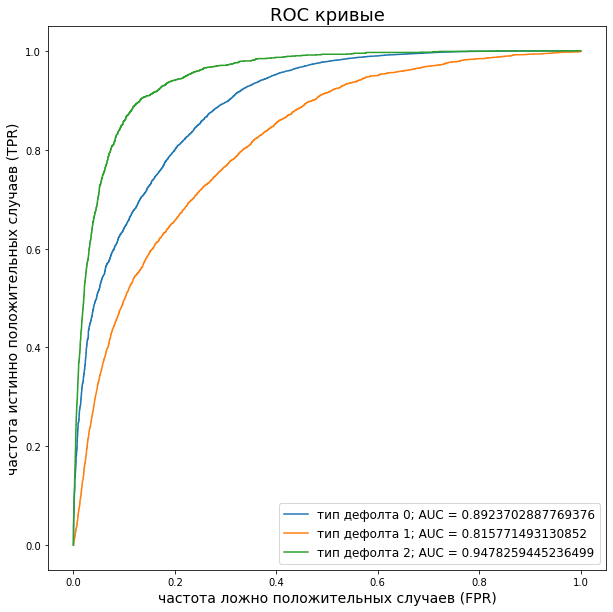

In [20]:
plt.figure(figsize = [10,10])

AUC_values = {};


for i in pred_probs.columns:
    test_y_pred = np.zeros(test_data.shape[0])
    test_y_pred[test_data.default_type == i] = 1;

    fpr, tpr, thresholds = metrics.roc_curve(test_y_pred, pred_probs[i] )
    plt.plot(fpr, tpr)
    AUC = metrics.roc_auc_score( test_y_pred,pred_probs[i])
    print('AUC для класса ' + str(i) + ' составил:' + str(AUC))
    AUC_values[i] = AUC

plt.ylabel('частота истинно положительных случаев (TPR)', fontsize = 14)
plt.xlabel('частота ложно положительных случаев (FPR)', fontsize = 14)
plt.title('ROC кривые', fontsize = 18)


plt.legend( ['тип дефолта ' + str(val) + '; AUC = ' + str(AUC_values[val])  for val in AUC_values],
            fontsize=12  )

plt.savefig('pirctures/ROC_ordered.png')
    